---
title: "2.5D DC Resistivity Inversion"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** DC resistivity, 2.5D inversion, sparse norm, tree mesh.

</br>

**Summary:** Here we invert DC resistivity data on a tree mesh to recover the subsurface distribution of electric properties. To demonstrate a range of functionality within SimPEG, we apply two approaches:

1. Weighted least-squares inversion, where we invert normalized voltage data to recover a log-conductivity model
2. Iteratively re-weighted least-squares (IRLS) inversion, where we invert apparent resistivity data to recover a log-resistivity model

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. The *iteratively re-weighted least-squares* approach is able to recover sparse and/or blocky structures. Because this tutorial focusses primarily on 
inversion-related functionality, we urge the reader to become familiar with functionality explained in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial before working through this one.

</br>

**Learning Objectives:**

- Introduce geophysical inversion with SimPEG.
- Assigning appropriate uncertainties to normalized voltage and apparent resistivity data.
- Designing a suitable mesh for 2.5D DC resistivity inversion.
- Choosing suitable parameters for the inversion.
- Specifying directives that are applied throughout the inversion.
- Apply the sensitivity weighting commonly used when inverting magnetic data.
- Inversion with weighted least-squares and sparse-norm regularizations.
- Analyzing inversion outputs.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to DC resistivity is imported from [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    generate_survey_from_abmn_locations,
    apparent_resistivity_from_voltage,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils import download, model_builder
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

## Load Tutorial Data and Plot

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_2d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_2d.txt"
data_filename = dir_path + "dc_data.obs"

overwriting /home/ssoler/git/user-tutorials/notebooks/05-dcr/inv_dcr_2d_files.tar.gz


   saved to: /home/ssoler/git/user-tutorials/notebooks/05-dcr/inv_dcr_2d_files.tar.gz
Download completed!


### Load the Topography

True surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray).
For the 2.5D problem geometry however, topography is an (N, 2) [numpy.ndarray](xref:numpy#numpy.ndarray), where the first coordinate represent along-line position and the second coordinate represents the vertical position. In this tutorial, we assume the topography and electrode locations are defined according to the 2.5D geometry.

In [3]:
# Load 2D topography
topo_2d = np.loadtxt(str(topo_filename))

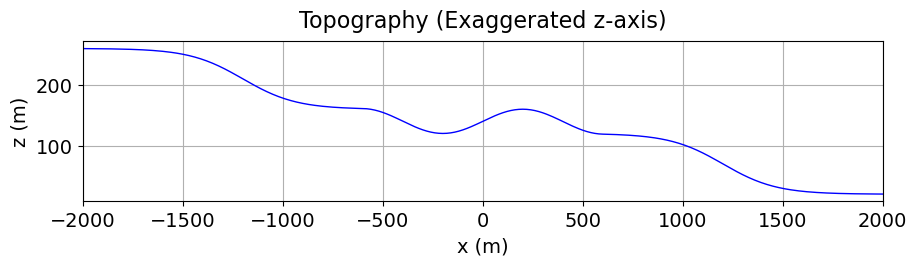

In [4]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=1)
ax.set_xlim([topo_2d[:, 0].min(), topo_2d[:, 0].max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

### Load DC Resistivity Data

**Option A: DCIP2D formatted data**

For this tutorial, the observed data are organized with a UBC-GIF DCIP2D formatted data file. We can use the [read_dcip2d_ubc](xref:simpeg#simpeg.utils.io_utils.read_dcip2d_ubc) utility function to load data in this format. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object. The data are normalized voltages in units V/A.

In [5]:
voltage_data = read_dcip2d_ubc(data_filename, "volt", "general")

**Option B: Survey from ABMN electrode locations**

If you have CSV-formatted data containing the ABMN electrode locations, you will need to:

* load the file into a [numpy.ndarray](xref:numpy#numpy.ndarray)
* extract the data column and the A, B, M and N electrode locations
* transform the electrode locations to the 2.5D geometry if necessary; i.e. (N, 2) [numpy.ndarray](xref:numpy#numpy.ndarray)
* use the [generate_survey_from_abmn_locations](xref:simpeg#simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations) to generate a [survey](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey) object automatically.
* Define a [Data](xref:simpeg#simpeg.data.Data) object attached to the survey and observed data.

E.g. for a file containing electrode locations already formatted for a 2.5D geometry:
```
data_array = np.loadtxt(data_filename, skiprows=1)

dobs = data_array[:, -1]
A = data_array[:, 0:2]
B = data_array[:, 2:4]
M = data_array[:, 4:6]
N = data_array[:, 6:8]

survey = generate_survey_from_abmn_locations(
    locations_a=A,
    locations_b=B,
    locations_m=M,
    locations_n=M,
    data_type='volt'
)

dc_data = data.Data(survey, dobs=dobs)
```

### Plot DC Resistivity Data in Pseudo-Section

Here we use the [plot_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_pseudosection) utility function to plot the normalized voltage data in pseudosection. We also use the [apparent_resistivity_from_voltage](simpeg#simpeg.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities, which are also plotted in pseudosection.

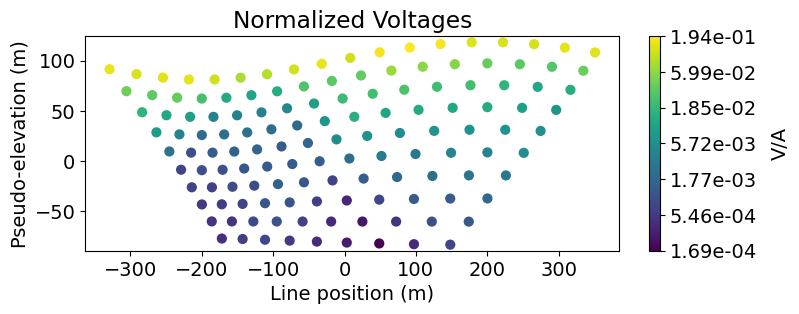

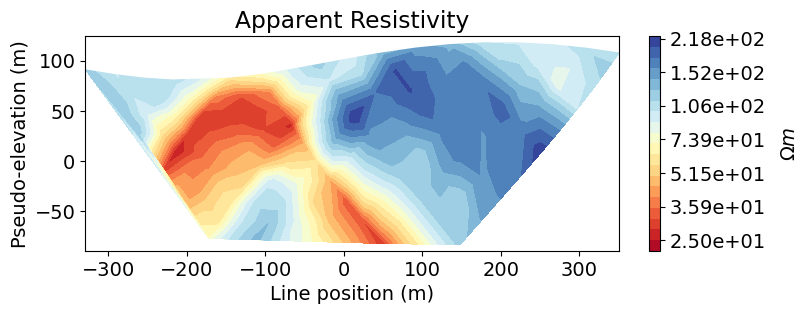

In [6]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**For normalized voltage data,** we generally apply a percent uncertainty and a very small floor uncertainty to all data. Differences in electrode spacing and subsurface conductivity result in measured voltages that span many orders of magnitude. A percent uncertainty ensures all data are fit equally. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages. Here, we apply uncertainties of 1e-7 V/A + 5 %.

**For apparent resistivity data,** we also apply a percent uncertainty and a very small floor uncertainty to all data. A percent uncertainty will fit conductive and resistive structures equally; unlike a floor uncertainty which will prioritize fitting more resistive structures. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages.

In [7]:
# Apply uncertainties to normalized voltage data
voltage_data.standard_deviation = 1e-7 + 0.05 * np.abs(voltage_data.dobs)

## Design a (Tree) Mesh

The same rules for defining appropriate meshes for forward simulation of DC resistivity apply to inversion. Please visit the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial to see the best practices for mesh design.

**Tutorial mesh:** Here, a minimum cell width of 4 m (or 1/10 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 400 m, so a the padding was extended at least 1200 m from the survey region. Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](xref:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [8]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, -1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = voltage_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

/tmp/ipykernel_2343514/724803012.py:10: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hz], x0="CN")


## Define the Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [9]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Project Electrodes to Discretized Topography

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to inverting DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [10]:
voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Weighted Least-Squares Inversion

Here, a weighted least-squares inversion approach is used to invert normalized voltage data to recover a log-conductivity model. We invert for log-conductivity because

1. It naturally enforces positive conductivity values in the recovered model
2. Electrical conductivity is a physical property that spans many orders of magnitude

### Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For whatever model we choose, we must define a mapping from the set of model parameters (a [1D numpy.ndarray](xref:numpy#numpy.ndarray)) to the physical property values of all cells in the mesh. Mappings are created using the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module.

For DC resistivity, the model parameters define the subsurface electrical conductivity, and the electrical conductivities of the cells in the air are given a fixed value. Here, the model defines the log-conductivity values for all active cells. We use the [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) to map from the model parameters to the conductivity values for all active cells. Then we use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) map to project the active cell conductivities to the entire mesh. As explained in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial, air cells are given a fixed value of 1e-8 S/m to ensure the forward problem is well-conditionned. And the $*$ operator is used to combine the separate mapping objects into a single mapping.

In [11]:
# Map model parameters to all cells
log_conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1e-8) * maps.ExpMap(
    nP=n_active
)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For DC resistivity inversion, the starting model is frequently a halfspace estimated from the set of apparent resistivities/conductivities.

The **reference model** is used to include a-priori information. By default, the starting model is set as the reference model. The impact of the reference model on the inversion will be discussed in another tutorial.

Notice that the length of the starting and reference models is equal to the number of model parameters!!!

In [12]:
# Median apparent resistivity
median_resistivity = np.median(apparent_resistivities)

# Create starting model from log-conductivity
starting_conductivity_model = np.log(1 / median_resistivity) * np.ones(n_active)

# Zero reference conductivity model
reference_conductivity_model = starting_conductivity_model.copy()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 2.5D DC resistivity was discussed in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial. Here, we use the [Simulation2DNodal](xref:simpeg#simpeg.electromagnetics.static.resistivity.Simulation2DNodal) simulation which solves for the electric potential on mesh nodes.

Since our model consists of log-conductivities, we use ``sigmaMap`` to set the mapping from the model to the mesh cells. Except for in extreme cases, we can compute and store the Jacobian explicitly for 2.5D problems. By doing so, we drastically reduce the run-time of the inversion.

In [13]:
voltage_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, sigmaMap=log_conductivity_map, storeJ=True
)

### Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [14]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=voltage_simulation, data=voltage_data)

### Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Here, the scaling constants that balance the smallness and smoothness terms are set directly. We use the inverse square of the smallest cell size to balance the smallness and smoothness terms. Setting ``alpha_s`` to a very small value will recover the smoothest model. And the reference model is only applied to the smallness term.

By default, the regularization acts on the model parameters; which in the case are the log-conductivities of the active cells. So we need to specify which cells are active in the regularization. And if we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [15]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    alpha_s=dh**-2,
    alpha_x=1,
    alpha_y=1,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

### Define the Optimization Algorithm

Here, we use the [InexactGaussNewton](xref:simpeg#simpeg.optimization.InexactGaussNewton) class to solve the optimization problem using the inexact Gauss Newton with conjugate gradient solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [16]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define the Inverse Problem

We use the [BaseInvProblem](xref:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [17]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of DC resistivity data and describe their roles. These are:

- [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights): Apply sensitivity weighting to counteract the natural tendency of DC resistivity inversion to place materials near the electrodes. Since the problem is non-linear and the sensitivities are updated with every model, we set `every_iteration=True`. For DC resistivity inversion, we do not want to use the entire dynamic range of the sensitivities to generate our weighting. So we generally set `threshold_value` to a value betwewen 1e-5 and 1e-3.

- [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent.

- [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [18]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](xref:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [19]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# recovered_model_L2 = inv_L2.run(np.log(0.01) * np.ones(n_param))
recovered_log_conductivity_model = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  1.67e+01  4.45e+04  0.00e+00  4.45e+04    5.33e+03      0              


   1  1.67e+01  1.55e+03  6.42e+01  2.63e+03    4.41e+02      0              


   2  8.37e+00  3.06e+02  8.54e+01  1.02e+03    6.04e+01      0   Skip BFGS  


   3  8.37e+00  1.68e+02  9.35e+01  9.51e+02    6.57e+00      0   Skip BFGS  


   4  4.19e+00  1.68e+02  9.39e+01  5.61e+02    3.03e+01      0              


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.4540e+03
1 : |xc-x_last| = 2.7356e+00 <= tolX*(1+|x0|) = 3.8957e+01
0 : |proj(x-g)-x|    = 3.0310e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.0310e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =      5
------------------------- DONE! -------------------------


### Plot the Data Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the normalized data misfit. As we can see, the recovered model reproduces the observed data quite well. And the normalized misfit map indicates we are not overfitting certain electrodes relative to others.

If desired, one could also use the [apparent_resistivity_from_voltage](simpeg#simpeg.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function compare observed and predicted data as apparent resistivities.

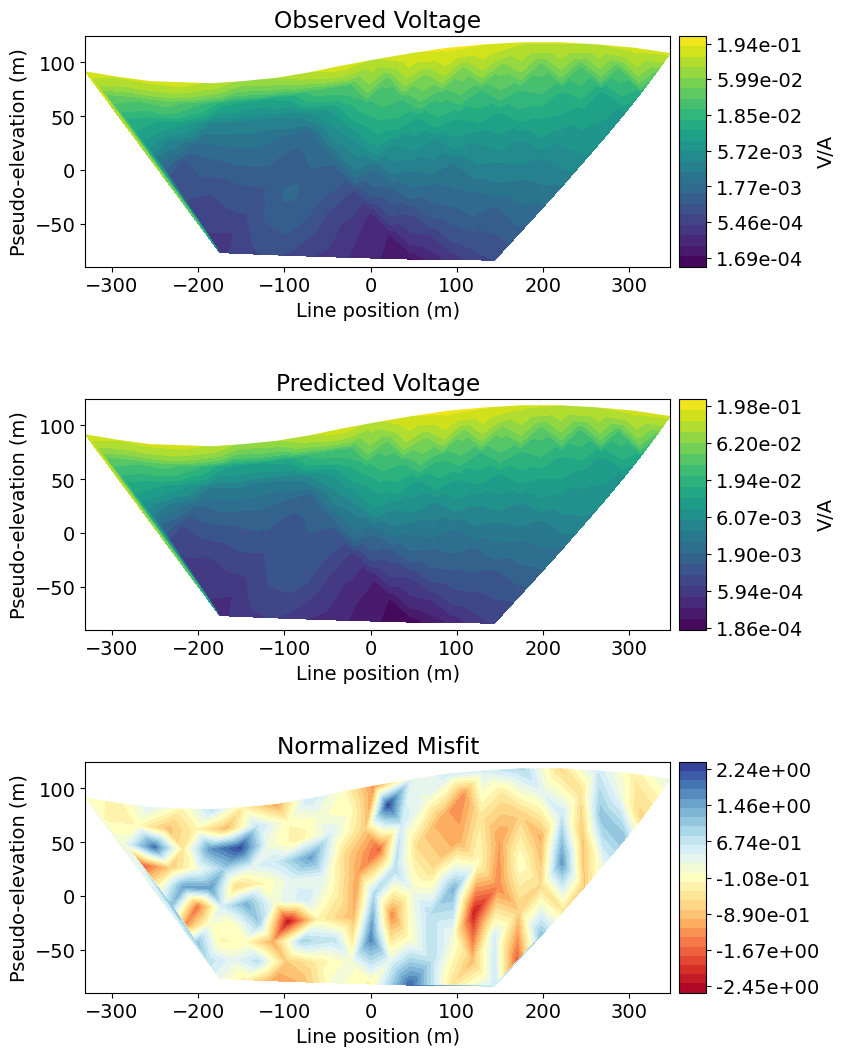

In [20]:
# Predicted data from recovered model
dpred = inv_prob_L2.dpred
dobs = voltage_data.dobs
std = voltage_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 11))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        voltage_data.survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### Plot the Recovered Model

As we can see, weighted least-squares regularization leads to the recovery of smooth models.

In [21]:
# Convert log-conductivity values to conductivity values
recovered_conductivity_L2 = np.exp(recovered_log_conductivity_model)

In [22]:
# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

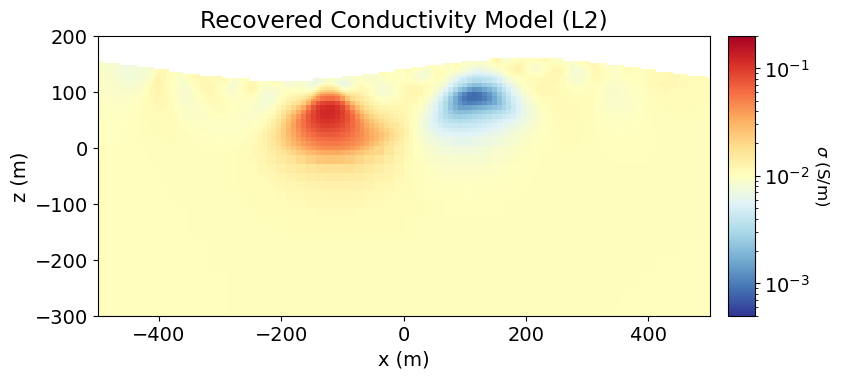

In [23]:
norm = LogNorm(vmin=5e-4, vmax=2e-1)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_conductivity_L2,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Recovered Conductivity Model (L2)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we provide a step-by-step best-practices approach for IRLS inversion of apparent resistivity data on a tree mesh to recover a log-resistivity model. Many of the steps are the same as our previous approach. As a result, we will avoid repeating information whenever possible.

### Define An Apparent Resistivity Survey

We cannot reuse a survey that was used to simulate a different data type. So we must define a new survey object for inverting apparent resistivity data. This can be done by extracting the ABMN electrode locations from the previous survey object and using the [generate_survey_from_abmn_locations](xref:simpeg#simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations) utility function.

In [24]:
# Extract ABMN electrode locations from previous survey object
locations_a = voltage_data.survey.locations_a.copy()
locations_b = voltage_data.survey.locations_b.copy()
locations_m = voltage_data.survey.locations_m.copy()
locations_n = voltage_data.survey.locations_n.copy()

# Define survey from ABMN locations
resistivity_survey = generate_survey_from_abmn_locations(
    locations_a=locations_a,
    locations_b=locations_b,
    locations_m=locations_m,
    locations_n=locations_n,
    data_type="apparent_resistivity",
)

# Set geometric factor for survey (to be handled internally in future versions)
resistivity_survey.set_geometric_factor()

### Define the Data

In [25]:
resistivity_data = data.Data(survey=resistivity_survey, dobs=apparent_resistivities)

### Assign Uncertainties

Uncertainties for apparent resistivity data were discussed earlier. Here we apply uncertainties of 1e-3 $\Omega m$ + 5 % to all data.

In [26]:
resistivity_data.standard_deviation = 1e-3 + 0.05 * np.abs(resistivity_data.dobs)

### Mapping from the Model to the Mesh

Here, the model defines the log-resistivity values for all active cells. We use the [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) to map from the model parameters to the resistivity values for all active cells. Then we use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) map to project the active cell resisitivities to the entire mesh. As explained in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial, air cells are given a fixed value of 1e8 $\Omega m$ to ensure the forward problem is well-conditionned. And the $*$ operator is used to combine the separate mapping objects into a single mapping.

In [27]:
log_resistivity_map = maps.InjectActiveCells(mesh, active_cells, 1e8) * maps.ExpMap(
    nP=n_active
)

### Starting/Reference Models

The starting model is defined according to the median apparent resistivity value. The reference model is equal to the starting model.

In [28]:
# Create starting model from log-resistivities
starting_resistivity_model = np.log(median_resistivity) * np.ones(n_active)

# Zero reference model
reference_resistivity_model = starting_resistivity_model.copy()

### Define the Forward Simulation

In [29]:
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=resistivity_data.survey, rhoMap=log_resistivity_map, storeJ=True
)

### Define the Data Misfit

In [30]:
dmis_irls = data_misfit.L2DataMisfit(
    simulation=resistivity_simulation, data=resistivity_data
)

### Define the Regularization

Here, we use the [Sparse](xref:simpeg#simpeg.regularization.Sparse) regularization class to constrain the inversion result using an IRLS approach. Length scales along x and y are used to balance the smallness and smoothness terms. Here, length scales of 100 are used to more strongly emphasize smoothness in the recovered model. The reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros. Here, we apply a 0-norm to the smallness and 2-norm to first-order smoothness along the x and y directions.

In [31]:
reg_irls = regularization.Sparse(
    mesh,
    active_cells=active_cells,
    length_scale_x=5.0,
    length_scale_y=5.0,
    norms=[0, 2, 2],
    reference_model=reference_resistivity_model,
)

### Define the Optimization Algorithm

In [32]:
opt_irls = optimization.InexactGaussNewton(
    maxIter=50, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define the Inverse Problem

In [33]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Provide Inversion Directives

Here, we create common directives for IRLS inversion of total magnetic intensity data and describe their roles. In additon to the [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights), [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner) and [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig)  (described before), inversion with sparse-norms requires the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive.

You will notice that we don't use the [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule) and [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit) directives. Here, the beta cooling schedule is set in the [`UpdateIRLS`](xref:simpeg#simpeg.directives.UpdateIRLS) directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach is set with the `chifact_start` property. 

In [34]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_irls = directives.UpdateIRLS(
    cooling_factor=2,
    cooling_rate=2,
    f_min_change=1e-4,
    max_irls_iterations=30,
    chifact_start=1.0,
)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

### Define and Run the Inversion

In [35]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_log_resistivity_model = inv_irls.run(starting_resistivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  1.17e+00  4.48e+04  0.00e+00  4.48e+04    5.38e+03      0              


   1  1.17e+00  1.94e+03  1.32e+03  3.48e+03    4.42e+02      0              


   2  5.86e-01  5.89e+02  1.82e+03  1.65e+03    9.71e+01      0   Skip BFGS  


   3  5.86e-01  3.11e+02  2.12e+03  1.55e+03    8.79e+00      0   Skip BFGS  


   4  2.93e-01  3.14e+02  2.11e+03  9.33e+02    5.90e+01      0              


   5  2.93e-01  1.88e+02  2.38e+03  8.86e+02    4.74e+00      0              


   6  1.46e-01  1.90e+02  2.38e+03  5.38e+02    3.21e+01      0              


Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 2.6445759891354164


   7  1.46e-01  1.32e+02  3.50e+03  6.44e+02    1.27e+01      0              


   8  1.46e-01  1.41e+02  3.46e+03  6.48e+02    4.41e+00      0              


   9  1.46e-01  1.42e+02  3.75e+03  6.92e+02    5.78e+00      0              


  10  1.46e-01  1.45e+02  3.76e+03  6.96e+02    2.06e+00      0              


  11  1.46e-01  1.46e+02  3.93e+03  7.21e+02    5.49e+00      0              


  12  1.46e-01  1.47e+02  3.95e+03  7.26e+02    2.01e+00      0              


  13  1.46e-01  1.49e+02  4.04e+03  7.41e+02    5.96e+00      0              


  14  9.44e-02  1.49e+02  4.07e+03  5.33e+02    1.78e+01      0              


  15  9.44e-02  1.24e+02  4.25e+03  5.25e+02    4.43e+00      0              


  16  6.08e-02  1.24e+02  4.27e+03  3.84e+02    1.25e+01      0              


  17  6.08e-02  1.09e+02  4.37e+03  3.74e+02    3.08e+00      0              


  18  7.83e-02  1.09e+02  4.38e+03  4.51e+02    7.39e+00      0              


  19  7.83e-02  1.18e+02  4.22e+03  4.48e+02    4.04e+00      0              


  20  9.68e-02  1.17e+02  4.22e+03  5.26e+02    7.67e+00      0              


  21  9.68e-02  1.28e+02  4.02e+03  5.17e+02    5.09e+00      0              


  22  1.20e-01  1.26e+02  4.03e+03  6.08e+02    9.35e+00      0              


  23  1.20e-01  1.40e+02  3.79e+03  5.94e+02    6.41e+00      0              


  24  1.48e-01  1.37e+02  3.80e+03  6.99e+02    1.14e+01      0              


  25  1.48e-01  1.55e+02  3.54e+03  6.79e+02    8.01e+00      0              


  26  9.49e-02  1.51e+02  3.55e+03  4.88e+02    2.11e+01      0              


  27  9.49e-02  1.28e+02  3.49e+03  4.59e+02    5.31e+00      0              


  28  6.08e-02  1.26e+02  3.47e+03  3.37e+02    1.46e+01      0              


  29  6.08e-02  1.12e+02  3.53e+03  3.26e+02    4.44e+00      0              


  30  7.68e-02  1.13e+02  3.48e+03  3.80e+02    7.57e+00      0              


  31  7.68e-02  1.19e+02  3.24e+03  3.68e+02    4.53e+00      0              


  32  9.39e-02  1.19e+02  3.21e+03  4.21e+02    7.91e+00      0              


  33  9.39e-02  1.26e+02  2.99e+03  4.07e+02    5.51e+00      0              


  34  1.15e-01  1.26e+02  2.97e+03  4.68e+02    9.35e+00      0              


  35  1.15e-01  1.35e+02  2.76e+03  4.52e+02    6.71e+00      0              


  36  1.41e-01  1.34e+02  2.74e+03  5.20e+02    1.09e+01      0              


  37  1.41e-01  1.44e+02  2.53e+03  5.00e+02    7.95e+00      0              


  38  1.72e-01  1.43e+02  2.52e+03  5.77e+02    1.24e+01      0              


  39  1.72e-01  1.55e+02  2.32e+03  5.55e+02    9.68e+00      0              


  40  1.10e-01  1.53e+02  2.32e+03  4.08e+02    2.30e+01      0              


  41  1.10e-01  1.32e+02  2.34e+03  3.90e+02    8.75e+00      0              


  42  7.02e-02  1.31e+02  2.33e+03  2.95e+02    1.61e+01      0              


  43  7.02e-02  1.20e+02  2.33e+03  2.83e+02    5.69e+00      0              


  44  8.59e-02  1.20e+02  2.31e+03  3.17e+02    6.92e+00      0              


  45  8.59e-02  1.23e+02  2.16e+03  3.09e+02    6.13e+00      0              


  46  1.05e-01  1.24e+02  2.14e+03  3.48e+02    7.88e+00      0              


  47  1.05e-01  1.28e+02  2.01e+03  3.39e+02    7.18e+00      0              


  48  1.28e-01  1.29e+02  1.99e+03  3.85e+02    9.00e+00      0              


  49  1.28e-01  1.33e+02  1.87e+03  3.74e+02    8.46e+00      0              


  50  1.57e-01  1.34e+02  1.86e+03  4.26e+02    1.03e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.2239e+01 <= tolF*(1+|f0|) = 4.4788e+03
1 : |xc-x_last| = 6.6250e-01 <= tolX*(1+|x0|) = 3.8957e+01
0 : |proj(x-g)-x|    = 1.0256e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.0256e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      50    <= iter          =     50
------------------------- DONE! -------------------------


## Plot True, L2 and IRLS Models

Here, we compare the models recovered from weighted least-squares and iteratively re-weighted least-squares inversion to the true model.

In [36]:
# Recreate the true model
true_background_conductivity = 1e-2
true_conductor_conductivity = 1e-1
true_resistor_conductivity = 1e-3

true_conductivity_model = true_background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_conductor] = true_conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_resistor] = true_resistor_conductivity

In [37]:
# Convert recovered log-resistivities to conductivities
recovered_conductivity_irls = 1 / np.exp(recovered_log_resistivity_model)

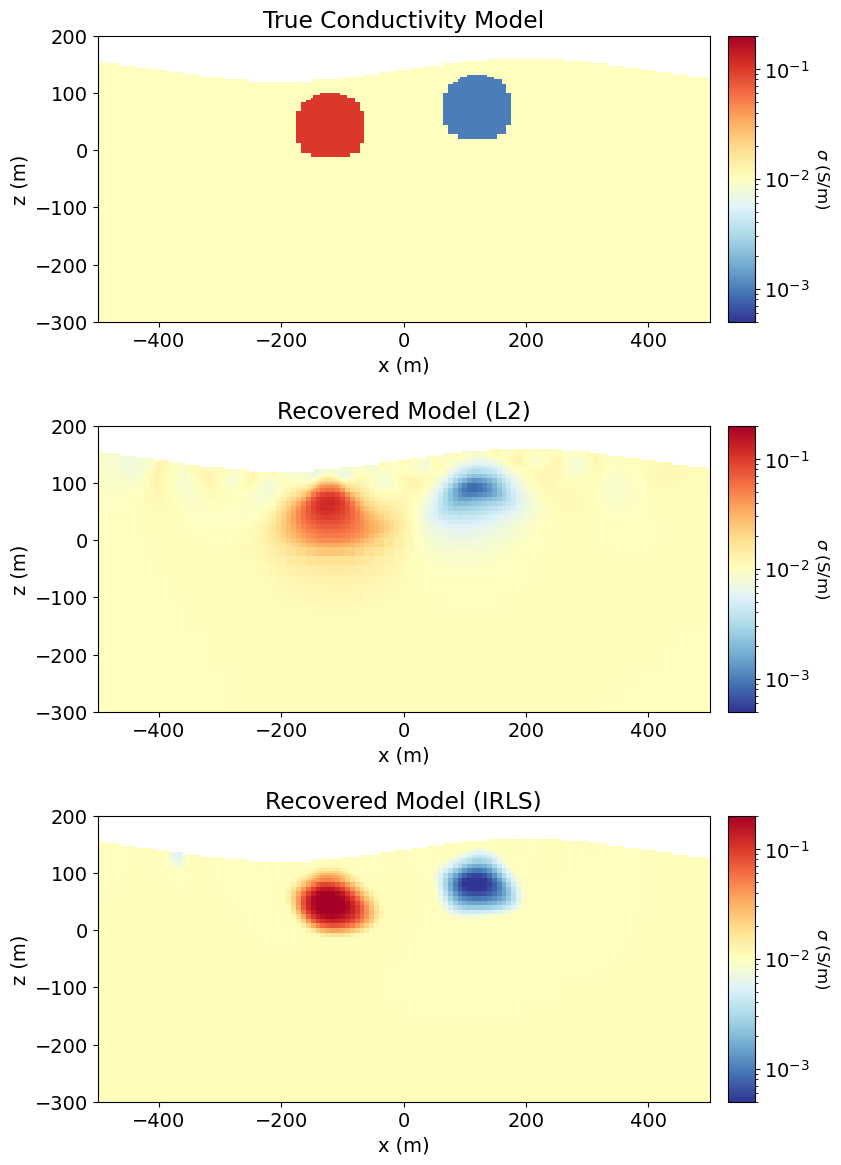

In [38]:
# Convert to subsurface conductivity values
plotting_model = [
    true_conductivity_model,
    recovered_conductivity_L2,
    recovered_conductivity_irls,
]

fig = plt.figure(figsize=(9, 13))
ax1 = 3 * [None]
ax2 = 3 * [None]
title_str = [
    "True Conductivity Model",
    "Recovered Model (L2)",
    "Recovered Model (IRLS)",
]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.14, 0.75 - 0.3 * ii, 0.68, 0.22])
    mesh.plot_image(
        plotting_map * plotting_model[ii],
        ax=ax1[ii],
        grid=False,
        pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
    )
    ax1[ii].set_xlim(-500, 500)
    ax1[ii].set_ylim(-300, 200)
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")

    ax2[ii] = fig.add_axes([0.84, 0.75 - 0.3 * ii, 0.03, 0.22])
    cbar = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()